In [1]:
api_key = '...'
serpapi_api_key="..."

# Ch7. Callbacks - 다양한 이벤트 발생 시 처리하기

### 01. Callbacks 모듈로 할 수 있는 일 알아보기

일반적으로 Callback은 특정 이벤트가 발생했을 때 호출되는 함수나 메서드를 의미</br>
랭체인에는 언어 모델을 사용해 애플리케이션의 다양한 단계에 개입할 수 있는 Callbacks 모듈이 존재

##### 로그 수집 및 모니터링, 다른 애플리케이션과 연동 가능

특징
- 애플리케이션의 상세한 실행 로그를 파일이나 터미널로 출력
- 외부 라이브러리, 애플리케이션과 연동하여 서로 다른 플랫폼이나 도구 간의 데이터 교환이 효율적
- 사용자가 직접 Callbakcs를 구현 가능하여 애플리케이션의 확장성을 높임

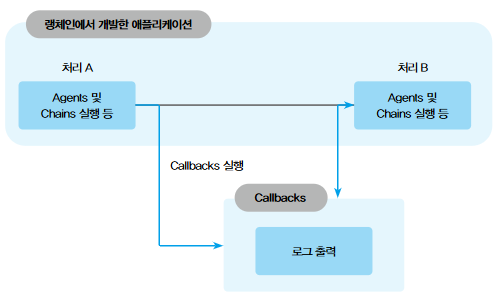

### 02. Callbacks 모듈을 사용해 외부 라이브러리와 연동하기

##### 준비된 클래스를 사용해 외부 라이브러리와 연동할 수 있다.

chainlit: 채팅 화면 생성 라이브러리

In [2]:
import chainlit as cl
from langchain.agents import AgentType, initialize_agent, load_tools
from langchain.chat_models import ChatOpenAI

In [3]:
chat = ChatOpenAI( 
    temperature=0,
    model="gpt-3.5-turbo",
    api_key = api_key
)

c:\Users\teo75\anaconda3\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [5]:
tools=load_tools(
    [
        "serpapi"        
    ],
    serpapi_api_key =serpapi_api_key
)
# tools=[serpapi]

In [6]:
agent=initialize_agent(tools=tools, llm=chat, agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

# on_chat_start  이벤트 핸들러
@cl.on_chat_start
async def on_chat_start():
    await cl.Message(content="Agent 초기화 완료").send()

# on_message 이벤트 핸들러
@cl.on_message
async def on_message(input_message):
    result=agent.run(
        input_message.content,                            # 주의: chainlit에서 대화창에서 받은 질문은 객체 형태로 넘어온다!!!(책하고 다른 부분)
        callbacks=[
            cl.LangchainCallbackHandler()
        ]
    )
    # agent의 응답을 사용자에게 전송
    await cl.Message(content=result).send()

c:\Users\teo75\anaconda3\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


LangchainCallbackHandler
- 메시지 전송 전후 처리: 에이전트가 사용자로부터 메시지를 수신하거나 응답을 전송하기 전에 특정 작업을 수행 가능
- 에이전트 실행 중 발생하는 에러를 처리하고, 필요에 따라 적절한 조치
-  에이전트의 실행 과정에서 발생하는 이벤트나 상태 변화를 기록하여 디버깅을 지원

### 03. 로그를 터미널에 표시할 수 있는 Callbacks 만들기

##### Callbacks 모듈을 직접 제작해 이벤트 발생 시 처리를 수행한다

StdOutCallbackHandler: 이벤트 발생시 터미널에 로그를 표시하는 기능

Chat model과 자체 제작한 Callbacks 모듈 결합

In [7]:
from langchain.callbacks.base import BaseCallbackHandler #← BaseCallbackHandler 가져오기
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

랭체인 Callbacks 모듈은 BaseCallbackHandler를 상속받은 클래스로 정의

In [8]:
class LogCallbackHandler(BaseCallbackHandler): #← Callback을 생성

    def on_chat_model_start(self, serialized, messages, **kwargs): #← Chat models 실행 시작 시 호출되는 처리를 정의
        print("Chat models 실행 시작....")
        print(f"입력: {messages}")

    def on_chain_start(self, serialized, inputs, **kwargs): #← Chain 실행 시작 시 호출되는 처리를 정의
        print("Chain 실행 시작....")
        print(f"입력: {inputs}")

In [9]:
chat = ChatOpenAI(
    model="gpt-4o",
    api_key = api_key,
    callbacks=[ #← Chat models 초기화 시 Callback을 지정
        LogCallbackHandler() #← 생성한 LogCallbackHandler를 지정
    ]
)

In [10]:
result = chat([
    HumanMessage(content="안녕하세요!"),
])

print(result.content)

c:\Users\teo75\anaconda3\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Chat models 실행 시작....
입력: [[HumanMessage(content='안녕하세요!')]]
2024-06-15 09:33:43 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
안녕하세요! 어떻게 도와드릴까요?


In [11]:
chat = ChatOpenAI(
    model="gpt-4o",
    api_key = api_key,
    # callbacks=[ #← Chat models 초기화 시 Callback을 지정
    #     LogCallbackHandler() #← 생성한 LogCallbackHandler를 지정
    # ]
)

result = chat([
    HumanMessage(content="안녕하세요!"),
])

print(result.content)

2024-06-15 09:34:02 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
안녕하세요! 어떻게 도와드릴까요?
